## Obligatorio de Deep Learning - Semestre 2 - 2022

## 1. Setup

### 1.1 Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/ORT/DeepLearning/Obligatorio/'

/content/drive/MyDrive/ORT/DeepLearning/Obligatorio


In [26]:
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf

from importlib import reload
import utils
utils = reload(utils)

### 1.2 Set random seeds

In [4]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [5]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [6]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [7]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### 3.1 Análisis descriptivo general: Distribuciones, Scatterplots, Barplots...

In [8]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


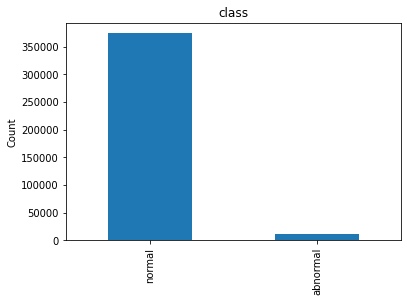

In [9]:
utils.value_counts(hdfs_train,'class')

### 3.2 Análisis de secuencias

In [10]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [32]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)
#raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
data_y.value_counts()

0    1  
0.0  1.0    374008
1.0  0.0     11281
dtype: int64

In [13]:
min([min(s) for s in raw_sequences])

1

In [14]:
max([max(s) for s in raw_sequences])

28

In [15]:
vocab_size = max([max(s) for s in raw_sequences]) + 1

In [16]:
max([len(s) for s in raw_sequences])

298

#### El valor de vocab_size es importante ya que es la dimensionalidad del lenguaje

#### Definiremos arbitrariamente el largo máximo de secuencias (es este tamaño razonable?)

In [17]:
max_len = 30

#### Haremos padding de valor 0 a las secuencias para estandarizar el largo

In [18]:
padded_sequences = utils.pad_sequences(raw_sequences, max_len)

## 4. Entrenamiento de Language Model

### 4.1. Data preprocessing
#### 4.1.1 Particionamiento

In [19]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

### 4.2 RNN

In [20]:
optimizer = 'adam'
loss = 'categorical_crossentropy'
import math
embedding_size = math.ceil(vocab_size**0.25) #es un hiperparametro. cuanto mas grande, mayor el entrenamiento

In [21]:
name='Doble_LSTM_7epochs_40ml'
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 3)             90        
                                                                 
 lstm (LSTM)                 (None, 30, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 50,652
Trainable params: 50,652
Non-trainable params: 0
_________________________________________________________________


### 4.3 Entrenamiento

#### 4.3.1 Hiperarámetros

In [22]:
batch_size = 10
epochs = 7
patience = 10

In [23]:
#se agregó class.weights
training1, model1 = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
26007/26007 [==============================] - 820s 31ms/step - loss: 0.0423 - accuracy: 0.9911 - val_loss: 0.0069 - val_accuracy: 0.9985
Epoch 2/7
26007/26007 [==============================] - 813s 31ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0052 - val_accuracy: 0.9993
Epoch 3/7
26007/26007 [==============================] - 809s 31ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 4/7
26007/26007 [==============================] - 816s 31ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 0.9989
Epoch 5/7
26007/26007 [==============================] - 835s 32ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 6/7
26007/26007 [==============================] - 816s 31ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 7/7
26007/26007 [==============================] - 829s 32ms/step - loss: 0.0041 - accuracy: 0.9991 - val_

### 4.4 Evaluación del modelo

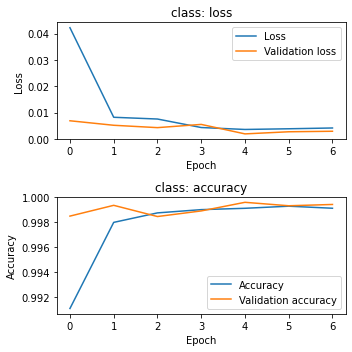

3011/3011 [==============================] - 41s 13ms/step


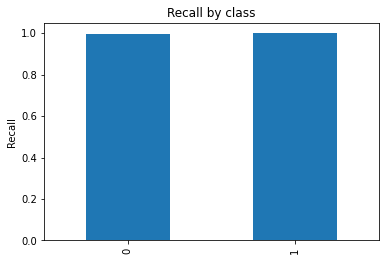

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      1.00      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.003348124213516712, accuracy: 0.9993147850036621


In [24]:
utils.eval_model(training1, model1, X_test, y_test)

## 5 Generación de salida para competencia Kaggle

In [33]:
utils.load_test_sequences_and_generate_prediction_file(model1, hdfs_test_kaggle, max_len, name)

5931/5931 [==============================] - 68s 11ms/step


,id,expected
0,0,normal
1,1,abnormal
2,2,normal
3,3,normal
4,4,normal
...,...,...
189765,189765,normal
189766,189766,normal
189767,189767,normal
189768,189768,normal


In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

Saved model to disk


## 6 Consigna

### A) Participación en Competencia Kaggle:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Macro Average Recall (o Weighted Accuracy) superior al 80%. [->Link a la competencia<-](https://www.kaggle.com/t/6d15e3a96bd049b2b4b2a491a69a0fc7).

### B) Utilización de Grid Search (o equivalente):
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible.

### C) Se debe a su vez investigar e implementar al menos 2 de las siguientes técnicas:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Data Augmentation a través de la realización de Windowing](https://blog.finxter.com/how-to-loop-through-a-python-list-in-batches/#Method_1_Iterating_over_Consecutive_Sliding_Windows)
#### 3. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)
